# Import Libraries

In this cell, we import the necessary Python libraries and modules required to build and train our deep learning model.  
We use Keras for deep learning, pandas for data manipulation, and other libraries for visualization and metrics evaluation.  
- `ImageDataGenerator`: For data augmentation and preprocessing  
- `Xception`: A pre-trained model for transfer learning  
- `Dense`, `GlobalAveragePooling2D`: For building custom layers  
- `EarlyStopping`: For stopping training once convergence is achieved  
- `confusion_matrix`, `classification_report`: For model evaluation



In [1]:
# --- Import Libraries ---

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Keras modules for model building
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


# Data Preparation

In this cell, we load and prepare the dataset.  
- We define the data directory path.
- Load class information from a CSV file.
- Filter the dataset to include only the selected art styles: **Impressionism**, **Cubism**, and **Abstract Expressionism**.
- Create a mapping of classes to integer indices (`class_to_index`).
- Define the expected input size for images (**img_width** and **img_height**) that match the input shape required by the Xception model.




In [2]:
# --- Data Preparation ---

# Define the data directory
data_dir = '/kaggle/input/wikiart/'

# Load the class information
class_df = pd.read_csv(os.path.join(data_dir, 'classes.csv'))

# Select three art styles
selected_styles = ['Impressionism', 'Cubism', 'Abstract_Expressionism']
class_df = class_df[class_df['genre'].isin(selected_styles)]

# Create a new class-to-index mapping
class_to_index = {style: i for i, style in enumerate(selected_styles)}
num_classes = len(class_to_index)

# Define image dimensions
img_width, img_height = 299, 299  # Xception's expected input size


# Data Augmentation and Generators

In this cell, we set up the data augmentation and create data generators for both the training and validation datasets.

- **Data Augmentation**:
  - Use `ImageDataGenerator` to rescale pixel values and apply random transformations (shearing, zooming, and horizontal flipping) to improve model generalization.
- **Training Generator**:
  - Automatically loads and preprocesses images from the `train` subset of the dataset.
- **Validation Generator**:
  - Similarly, loads and preprocesses images from the `validation` subset.

These generators automatically handle the batching and preprocessing of images for training and validation.



In [3]:
# --- Data Augmentation and Generators ---

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    data_dir, 
    target_size=(img_width, img_height), 
    batch_size=32, 
    class_mode='categorical', 
    classes=list(class_to_index.keys()), 
    subset='training',
    shuffle=True,
    seed=42
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    classes=list(class_to_index.keys()),
    subset='validation'
)


Found 14462 images belonging to 3 classes.
Found 3615 images belonging to 3 classes.


# Build the Xception Model (Transfer Learning)

In this cell, we create the deep learning model using transfer learning with the Xception architecture.

- **Load Pre-Trained Model**:
  - Use the Xception model with weights pre-trained on the ImageNet dataset.
  - Exclude the top layers to modify the architecture according to our needs.
  
- **Freeze Layers**:
  - Freeze the base model layers to retain the learned weights from ImageNet training and only train the new top layers.
  
- **Custom Classification Head**:
  - Add a `GlobalAveragePooling2D` layer to reduce the output dimensions.
  - Use the `Dense` layer with a softmax activation function for multi-class classification across the selected art styles.

- **Compile the Model**:
  - Use the Adam optimizer and categorical cross-entropy loss function to train the model.



In [4]:
# --- Build the Xception Model (Transfer Learning) ---

# Load the pre-trained Xception model without the top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train the Model

In this cell, we train the deep learning model using the training dataset while evaluating it on the validation dataset.

- **Training Configuration**:
  - Train the model for **10 epochs**.
  - Use the `fit()` method with both the `train_generator` and `validation_generator`.
  - Keras automatically handles the training and validation data fetching in batches.

- The early stopping callback ensures training stops once the validation loss no longer decreases, helping prevent overfitting.



In [5]:
# --- Train the Model ---

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734188818.313474     107 service.cc:145] XLA service 0x7bc4c0003250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734188818.313535     107 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734188818.313542     107 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-14 15:07:06.359588: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,

  1/452 ━━━━━━━━━━━━━━━━━━━━ 4:26:13 35s/step - accuracy: 0.5312 - loss: 1.0797

I0000 00:00:1734188838.621979     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8503 - loss: 0.4068

2024-12-14 15:20:45.587837: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[31,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-14 15:20:45.591297: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.003597646s
Trying algorithm eng3{k11=2} for conv (f32[31,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queu

452/452 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step - accuracy: 0.8504 - loss: 0.4066 - val_accuracy: 0.9145 - val_loss: 0.2277
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 587s 1s/step - accuracy: 0.9228 - loss: 0.2163 - val_accuracy: 0.9145 - val_loss: 0.2182
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 587s 1s/step - accuracy: 0.9308 - loss: 0.1940 - val_accuracy: 0.9184 - val_loss: 0.2143
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 590s 1s/step - accuracy: 0.9323 - loss: 0.1867 - val_accuracy: 0.9212 - val_loss: 0.2122
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 579s 1s/step - accuracy: 0.9357 - loss: 0.1777 - val_accuracy: 0.9159 - val_loss: 0.2114
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 577s 1s/step - accuracy: 0.9382 - loss: 0.1761 - val_accuracy: 0.9212 - val_loss: 0.2036
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 604s 1s/step - accuracy: 0.9385 - loss: 0.1715 - val_accuracy: 0.9184 - val_loss: 0.2104
Epoch 8/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.9449 - loss: 0.1547 - val_accuracy: 0.920

# Model Evaluation - Compute Metrics

In this cell, we evaluate the model performance using a series of important metrics.

- **Generate Predictions**:
  - Use the model to predict the classes of the images in the validation dataset.
  
- **Confusion Matrix**:
  - Compute and visualize the confusion matrix to identify misclassifications.
  - Plot the confusion matrix as a heatmap for better visual interpretation.

- **Classification Report**:
  - Display key metrics like **Precision**, **Recall**, and **F1 Score** for each class.

- **ROC and AUC Visualization**:
  - Generate ROC curves and calculate the AUC scores for each class.
  - Plot the ROC curves to evaluate the trade-off between true positive and false positive rates.

These metrics help assess how well the model classifies images across the selected art styles and where it may improve.



113/113 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step
Classification Report:
                        precision    recall  f1-score   support

         Impressionism       0.72      0.72      0.72      2612
                Cubism       0.12      0.13      0.12       447
Abstract_Expressionism       0.17      0.16      0.17       556

              accuracy                           0.56      3615
             macro avg       0.34      0.34      0.34      3615
          weighted avg       0.56      0.56      0.56      3615



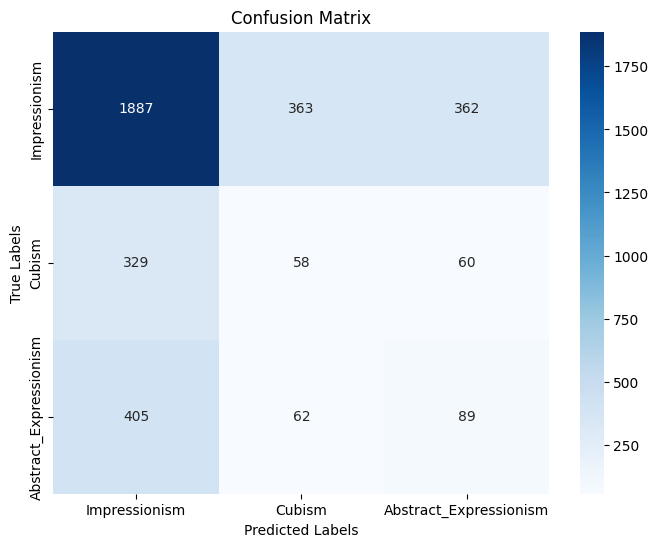

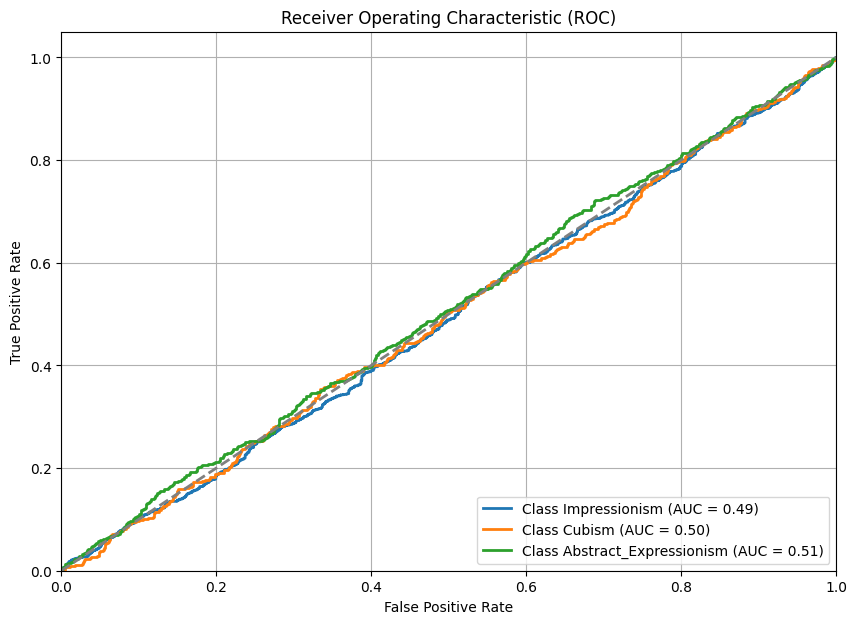

In [6]:
# --- Model Evaluation - Compute Metrics ---

# Predict the classes on the validation dataset
validation_generator.reset()  # Ensure we start from the beginning of data
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(class_to_index.keys())

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate ROC and AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], '--', lw=2, color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
